In [2]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings
import glob
import random
import pickle
import dev_wtp_io_utils
import gc #garbage collection
from nilearn import plotting
from dev_wtp_io_utils import cv_train_test_sets, asizeof_fmt
from sklearn.model_selection import KFold,GroupKFold,LeaveOneOut
import os, warnings

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
#custom thing I have set in my jupyter notebook task.
cpus_available = int(os.getenv('CPUS_PER_TASK'))
print(cpus_available)

4


In [4]:
pd.set_option('display.max_rows', 99)

This document starts with the nested cross-validation in `Wtp_train_avg_test_ind_nested_cv`.

We then apply Dasa's suggestion to measure performance within-subject. rather than trying to calculate $r^2$ across the entire set, we look at how well training can get a good $r^2$ _within_ each subject in the dataset.

It might be helpful to extend this logic somehow to the training as well as final evaluation. But let's see.

Since the previous analysis found that it wasn't helpful to analyze average data and then classify on individual; I'll restrict to analyzing individual data.

### Load brain data

In [5]:
test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

In [6]:
with open('../data/Brain_Data_2sns_60subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)
    
dev_wtp_io_utils.check_BD_against_test_train_set(Brain_Data_allsubs,test_train_set)

checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


### Preprocess

In [7]:
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()
print(Brain_Data_allsubs.Y.value_counts())
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
print(Brain_Data_allsubs.Y.value_counts())
print(Brain_Data_allsubs.Y.isnull().value_counts())
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
False    3690
True      150
Name: response, dtype: int64
3690
3840


In [8]:
all_subs_nn_nifti = Brain_Data_allsubs_nn.to_nifti()
all_subs_nn_nifti_Y = Brain_Data_allsubs_nn.Y
all_subs_nn_nifti_groups = Brain_Data_allsubs_nn.X.subject
all_subs_nn_nifti_groups

0       DEV001
1       DEV001
2       DEV001
3       DEV001
4       DEV001
         ...  
3685    DEV089
3686    DEV089
3687    DEV089
3688    DEV089
3689    DEV089
Name: subject, Length: 3690, dtype: object

In [9]:
all_subs_nn_nifti_metadata = Brain_Data_allsubs_nn.X

### Get subset

In [10]:
del Brain_Data_allsubs
#del Brain_Data_allsubs_grouped
gc.collect()

30

In [11]:
from nilearn.decoding import DecoderRegressor
dRegressor = DecoderRegressor(estimator = 'ridge_regressor', standardize= True,scoring="r2")

In [12]:
import sys
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print(name + ': ' + str(size))

all_subs_nn_nifti_metadata: 2484304
__: 232614
all_subs_nn_nifti_groups: 232614
_8: 232614
all_subs_nn_nifti_Y: 29664
test_train_set: 9549
DecoderRegressor: 1472
KFold: 1064
GroupKFold: 1064
LeaveOneOut: 1064


In [13]:
asizeof_fmt(Brain_Data_allsubs_nn)

'3.3 GiB'

In [14]:
asizeof_fmt(all_subs_nn_nifti)

'12.4 GiB'

As a control, we'll try this again, this time just training and testing on individual values:

get a small sample of subjects to extract

In [15]:
sample_subject_items = np.unique(all_subs_nn_nifti_groups)[0:30]

In [16]:

sample_subject_vector = [i for i, x in enumerate(all_subs_nn_nifti_groups) if x in sample_subject_items]
#sample_grouped_subject_vector = [i for i, x in enumerate(all_subs_grouped_nifti_groups) if x in sample_subject_items]

In [17]:
first_subs_nifti = nib.funcs.concat_images([all_subs_nn_nifti.slicer[...,s] for s in sample_subject_vector])
first_subs_nifti_Y = all_subs_nn_nifti_Y[sample_subject_vector]
first_subs_nifti = nil.image.clean_img(first_subs_nifti,detrend=False,standardize=True)
first_subs_nifti_groups = all_subs_nn_nifti_groups[sample_subject_vector]

del all_subs_nn_nifti
gc.collect()

94

In [18]:
first_subs_nifti_metadata = all_subs_nn_nifti_metadata.loc[sample_subject_vector,:]

In [19]:
first_subs_nifti_metadata.shape

(1835, 19)

In [20]:
first_subs_nifti.shape

(91, 109, 91, 1835)

In [21]:
cv_outer = KFold(n_splits=3)

### Predict

Regressing in nilearn:
 - https://nilearn.github.io/decoding/estimator_choice.html
 - http://www.ncbi.nlm.nih.gov/pubmed/20691790







### Predict with the modified evaluation

Don't make it too complicated. If we have to pull this function apart and build a new one, then do that; don't waste time trying to be compatible with everything built within this function.

We're basically trying to design a 'grouped scorer'. To do this we'd need to somehow pass in the groups to the scorer. Can we do that?

Working with the DecoderRegressor, you pass in a scorer with the signature:

> scorer(estimator, X_test, y_test)

https://nilearn.github.io/modules/generated/nilearn.decoding.DecoderRegressor.html

It's pretty strict that that has to be the format. So X_test would have to contain the groups. Currently it doesn't, though. It might not be harmful to put a group identifier in X_test as an extra 'voxel' indicating which subject the data came from but it would be a bit of a hack.

It seems like nilearn uses `sklearn.metrics.check_scoring` and actually pasess the scorer function to this function:

(https://github.com/nilearn/nilearn/blob/297b1509/nilearn/decoding/decoder.py#L497).

That function has the signature:

And the documentation says that the scorer object has to have a similar function:
    
>        scoring : str or callable, default=None
>        A string (see model evaluation documentation) or
>        a scorer callable object / function with signature
>        ``scorer(estimator, X, y)``.
>        If None, the provided estimator object's `score` method is used.


So we would have to do the trick where a specific value in X stores a grouping variable. Then, we could probably create a wrapper for $r^2$ which scores within group.

https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

However, as I said before, this would be a hack because we have to put the grouping variable as an extra data point in X and that might cause problems.

You can use the `make_scorer` function where you pass in a score function that takes `y`, `y_pred` and arbitrary `**kwargs`. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer).

However it seems like those parameters need to be passed to the `make_scorer` as it is created - not derived from the data. This is because `make_scorer` is quite prescriptive that it 

> returns a callable that scores an estimator’s output. The signature of the call is `(estimator, X, y)` where `estimator` is the model to be evaluated, `X` is the data and `y` is the ground truth labeling (or None in the case of unsupervised models).

So there's no way to have group passed in.

So we might have to do something quite customized. But in the meantime, let's just try it in evaluating the model's final performance, and not include it in any nested CV.

In [22]:
def cv_train_test_sets(
    trainset_X, trainset_y, trainset_groups,
    regressors = None,
    testset_X = None,testset_y = None, testset_groups = None,
    param_grid=None,
    cpus_to_use=-2,
    cv = None):
    """
    uses a division of 'trainset' and 'testset' to allow different values to be trained and tested 
    in KFold Cross Validation. All the values are used for training and testing, but we use different ones.
    This enables us to e.g., pass in aggregated images for training and separate images for testing.
    
    trainset_X: x values applicalbe for TRAINING
    trainset_y
    trainset_groups: group allocations for the trainset dataset
    testset_X: values grouped into averages for testing
    testset_y
    cv: a Grouped cross-validator
    group_list: name of the groups
    """
    if cv is None:
        cv=KFold(n_splits=5)
        
    if param_grid is not None and regressors is not None:
        raise Exception('values for param_grid and regressors both passed, but param_grid is ignored if regressors is passed. choose one.')
    
    #if the groups we're using are actually the same.
    if (testset_X is None) and (testset_y is None):
        testset_X = trainset_X
        testset_y = trainset_y
        testset_groups = trainset_groups
        print('Groups are the same.')
        
    results_by_trainset_item = pd.DataFrame({
        'y': trainset_y,
        'group':trainset_groups,
        'y_pred':np.repeat(None,len(trainset_y))#,
        #'y_match':np.repeat(None,len(trainset_y))#just for debugging. delete.
    })
        

    groups_array = np.array(list(set(testset_groups)))
    assert(set(trainset_groups)==set(testset_groups))

    #the CV that the inner Regressor uses
    cv_inner = GroupKFold(3)
    if regressors is None:
        regressors = [DecoderRegressor(standardize= True,param_grid=param_grid,cv=cv_inner,scoring="r2",
                                      n_jobs=cpus_to_use)]
        print('using default regressor',end='. ')

    #we actually use KFold on the group names themselves, then filter across that
    #that's equivalent to doing a GroupedKFold on the data.
    test_scores = []
    results = []
    
    outer_n = cv.get_n_splits()
    for i, x in enumerate(cv.split(groups_array)):
        train_i = x[0]
        test_i = x[1]
        print("fold " + str(i+1) + " of " + str(outer_n))
        
        fold_i_results = {}
        train_group_items, test_group_items = groups_array[train_i], groups_array[test_i]
        print('In order to test on a training group of ' +
              str(len(train_group_items)) + ' items, holding out the following subjects:' +
              str(test_group_items),end='. ')
#         print(
#             'held out ' + str(len(test_group_items)) + ' items and trained on ' + str(len(train_group_items)) + ' items',
#             end='. ')
        
        print('prepping fold data...',end='. ')
        #select training data from the averages
        #print('selecting training data',end='. ')
        train_selector = [i for i, x in enumerate(trainset_groups) if x in train_group_items]
        train_y = trainset_y[train_selector]
        train_X = nib.funcs.concat_images([trainset_X.slicer[...,s] for s in train_selector])
        train_groups = trainset_groups[train_selector]
        #print(train_X.shape,end='. ')
        #print(asizeof_fmt(train_X),end='. ')

        #select testing data from the individual values
        #print('selecting test data',end='. ')
        test_selector = [i for i, x in enumerate(testset_groups) if x in test_group_items]
        test_y = testset_y[test_selector]
        test_X = nib.funcs.concat_images([testset_X.slicer[...,s] for s in test_selector])
        test_groups = testset_groups[test_selector]
        #print(asizeof_fmt(test_X),end='. ')
        #print(test_X.shape,end='. ')


        print("regressing...",end='. ')
        print(asizeof_fmt(train_X),end='. ')
        
        val_scores = []
        #iterate through regressor objects.
        #this is my way of doing cross-validation across different regressors...
        hyper_scores = []
        train_results = {}
        inner_cv_results = {}
        for r_i, reg in enumerate(regressors):
            cur_r_results = {}
            print('trying regressor ' + str(r_i+1) + ' of ' + str(len(regressors)),end='. ')
            #if there is nested CV within this function the best hyper-paramters are already being chosen
            #we need only to finish the job by identifying the best overall regressor, as the final hyper-parameter
            reg.fit(y=train_y,X=train_X,groups=train_groups)
            print("predicting",end='. ')
            #hyper_score = reg.score(train_X,train_y)
            hyper_score = np.max([np.mean(param_values) for param_name, param_values in reg.cv_scores_.items()])
            #think there is a bug here. we should not have to be guessing/ignoring param names.
            #need to report this.
            
            hyper_scores = hyper_scores + [hyper_score]
            
            cur_r_results['hyper_score'] = hyper_score
            cur_r_results['cv_scores_'] = reg.cv_scores_
            cur_r_results['cv_params_'] = reg.cv_params_
            inner_cv_results[str(reg)] = cur_r_results
            
        fold_i_results['train_results']= inner_cv_results
        
        #identify which was the best
        #print(hyper_scores)
        #print(np.where([h==np.max(hyper_scores) for h in hyper_scores])[0][0])
        best_hyper_regressor = regressors[np.where([h==np.max(hyper_scores) for h in hyper_scores])[0][0]]
        
        #print(best_hyper_regressor)
        
        #now run JUST that one on this fold.
        
        
        #now predict on our test split
        test_score = best_hyper_regressor.score(test_X,test_y)
        test_y_pred = best_hyper_regressor.predict(test_X)
        fold_test_rawdata = pd.DataFrame({
            'y_obs':test_y,
            'y_pred':test_y_pred,
            'y_groups':test_groups
            
        })
        #results_by_trainset_item.loc[train_selector,'y_pred']
        results_by_trainset_item.loc[test_selector,'y_pred'] = test_y_pred
        #results_by_trainset_item.loc[test_selector,'y_match'] = test_y
        fold_i_results['fold_test_rawdata'] = fold_test_rawdata
        #so we can do scoring externally to this function.
        
        test_scores = test_scores+[test_score]
        print('test score was:',end='. ')
        print(test_score)
        
        results = results + [fold_i_results]

        del test_X
        del train_X
        gc.collect() #clean up. this is big data we're working with
        #https://stackoverflow.com/questions/1316767/how-can-i-explicitly-free-memory-in-python
        

    #We could use predefined split
#     warnings.warn(
#         "regressor was chosen based on train score across the entire train group, not the test fold of the inner CV." +
#         "Overall accuracy is not biased but this may yield a sub-optimal regressor selection." +
#         "The alternative, testing on the main holdout set, as described in the nilearn example, may overfit the data (see "+
#         "https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)." + 
#         "this problem could be addressed with the use of a PredefinedSplit." + 
#         "See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html")

    return(test_scores,results,results_by_trainset_item)

In [23]:
test_scores_same,tt_results,results_by_trainset_item = cv_train_test_sets(
    trainset_X=first_subs_nifti,
    trainset_y=first_subs_nifti_Y,
    trainset_groups=first_subs_nifti_groups,
    cv=cv_outer,
    cpus_to_use=cpus_available-1
    
)



Groups are the same.
using default regressor. fold 1 of 3
In order to test on a training group of 20 items, holding out the following subjects:['DEV027' 'DEV025' 'DEV029' 'DEV039' 'DEV022' 'DEV019' 'DEV034' 'DEV013'
 'DEV010' 'DEV005']. prepping fold data.... regressing.... 8.3 GiB. trying regressor 1 of 1. predicting. test score was:. 0.23344612843461943
fold 2 of 3
In order to test on a training group of 20 items, holding out the following subjects:['DEV009' 'DEV023' 'DEV040' 'DEV017' 'DEV026' 'DEV001' 'DEV028' 'DEV014'
 'DEV018' 'DEV012']. prepping fold data.... regressing.... 8.2 GiB. trying regressor 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.22922308477611653
fold 3 of 3
In order to test on a training group of 20 items, holding out the following subjects:['DEV035' 'DEV041' 'DEV024' 'DEV006' 'DEV015' 'DEV021' 'DEV042' 'DEV036'
 'DEV030' 'DEV016']. prepping fold data.... regressing.... 8.2 GiB. trying regressor 1 of 1. 

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/decoding/decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


predicting. test score was:. 0.229429325564372


In [24]:
print(test_scores_same[0])
print(np.mean(test_scores_same[0]))

0.23344612843461943
0.23344612843461943


In [25]:
import pickle
with open("../data/cv_train_test_sets_outer_n_split3.pkl", 'wb') as handle:
    pickle.dump([test_scores_same,tt_results,results_by_trainset_item],handle)

Now combine the metadata and the results.

In [27]:
np.sum(results.subject==results.group)

1835

In [28]:
results['result_group'] = results.group + "_" + results.run

In [29]:
results.y_pred = results.y_pred.astype('float')

In [30]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import math

In [31]:
r2_score(results['y'],results['y_pred'])

0.23184109193532398

In [61]:
np.mean(test_scores_same)

0.230699512925036

Not quite the same, but close enough. Now do this within-subject.

In [33]:
%matplotlib inline

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

### r^2 is not hte same as pearson's r and if we use it per-subject it performs LESS well

In [35]:
within_subj_predictions = []
for group in results['result_group'].unique():
    group_results = results.loc[results['result_group']==group,]
    within_subj_prediction = r2_score(group_results['y'],group_results['y_pred'])
    print(within_subj_prediction)
    print(math.pow(pearsonr(group_results['y'],group_results['y_pred'])[0],2))
    print(math.pow(spearmanr(group_results['y'],group_results['y_pred'])[0],2))
    #what if we we re-ranked the predicted values into groups along the 
    if (within_subj_prediction< (-0.5)):

#         sp = sns.scatterplot(group_results['y'],group_results['y_pred'])
#         plt.show()
        display(pd.DataFrame(group_results.groupby('y').y_pred.mean()))
        #display(group_results)
    within_subj_predictions = within_subj_predictions + [within_subj_prediction]
    print("")
    
r2_score_within_subj = np.mean(within_subj_predictions)

0.18448045278305858
0.4038845411941005
0.4574117647058824

0.7604778572515768
0.7683425392290582
0.7414215686274508

0.7580007359686911
0.8418578702111166
0.830205882352941

0.4249407528196929
0.5338231136829967
0.5388863750628454

0.04882559324770386
0.10933380000292894
0.09886425834701695

0.36162176409003843
0.4623387451283155
0.41961709211986686

0.3724461006554175
0.44733103221498444
0.371526409606905

0.430605133386442
0.4742039438296478
0.5064372918978913

0.3351895353205203
0.5400389408113974
0.6363636363636362

-0.07643587827236353
0.3074700466102745
0.2814406900484744

0.415759463687958
0.6761542475909395
0.71245451788963

0.2759520670273129
0.4883198299363143
0.5841013824884792

0.0879677310885385
0.2393341789428092
0.1590416936005171

0.4318894382190872
0.4504168315976383
0.5446120689655172

-0.06319530235815662
0.012432629203534802
0.003263497179693796

-0.26890545832076485
0.048008451551180165
0.02412114845938375

0.22565046541911193
0.36117087803143916
0.3812144060319242

,y_pred
y,
5.0,6.063357
6.0,6.799573
8.0,6.303735



-0.3031566138895321
0.6444128142669682
0.6732467532467532

0.7407216945997132
0.8324031999091119
0.8008156791661946

0.6547069992140107
0.6817463650018022
0.6454870129870128

-0.9374337531901944
0.06559247822295038
0.006617647058823529


,y_pred
y,
5.0,6.911062
6.0,5.926919
7.0,6.044470



-0.9301678228326875
0.006424728453203575
0.016780051150895137


,y_pred
y,
5.0,6.953813
6.0,5.600842
7.0,6.216995
8.0,6.258036



-0.3907641782283322
0.12202811886583383
0.07313364055299537

-0.08247470617357378
0.1631709701488646
0.17556010230179023

-1.4041754021152468
0.262019105761913
0.1959028625695292


,y_pred
y,
6.0,5.686497
7.0,6.016576
8.0,6.258668



-1.9348283271300972
0.1072930471622808
0.11080586080586076


,y_pred
y,
6.0,6.006662
7.0,5.915257
8.0,6.373382



-3.160324017065551
0.004703089997567484
0.006060606060606061


,y_pred
y,
6.0,5.596162
7.0,5.826329
8.0,5.658948



-1.1642430340495182
0.20078470144579386
0.22252747252747257


,y_pred
y,
6.0,5.802394
7.0,6.125536
8.0,6.335625



0.05991295470944413
0.4669578456067224
0.4493758668515949

0.36172645722938734
0.377079565881863
0.44028059499661926

0.15756030510572105
0.330160114165769
0.37065140489185344

0.5416066794651255
0.6129815060425243
0.6188220262551359

0.36375093286623383
0.38416798134225716
0.4662004662004663

-0.18030515668067415
0.09843571800016637
0.07302129968796636

0.22984430330498729
0.2605998375031535
0.16071428571428578

-0.11894279008147968
0.09015540585043684
0.04363636363636364

-0.08769611858774784
0.014330171743296453
0.017095533865720196

-0.3127260955394411
0.023061337191002906
0.0446664790318041

-0.09908132479708831
0.255862829836177
0.19276960784313718

0.3097152224760171
0.34030233724732106
0.35392156862745094

0.45654897853708154
0.4934023606130706
0.5084948383326842

0.42522361871652303
0.5362955103503682
0.3498299319727891

-0.33920165571376826
0.007555118487714411
0.009220430107526883

0.17363908306528597
0.18122177034987236
0.11363940698230511

0.23721529255796603
0.3493566890

,y_pred
y,
5.0,5.593348
6.0,6.296632
8.0,5.336284



-0.24688228802069578
0.04276219899587339
0.039030396847734294

0.6145971989989882
0.683816086722149
0.7248864574731628

0.1270744420865475
0.17041265195176844
0.16542597961283084

0.10345541135126124
0.11400892286253045
0.13509710104137346

0.43385465076837026
0.6251300132093537
0.6127305257363063

0.24951281324366648
0.2750821445399093
0.3429702374987475

0.3359191307365169
0.507574937183257
0.4968756107094001

0.07762453903513755
0.10638184532031379
0.131094851733797

-0.06562213239116943
0.07335145699264395
0.03200458243710838

0.16032692800365478
0.20476531452249194
0.1505656108597285

0.16974535824465142
0.39744643065223023
0.4113533525298232

0.6464777962100072
0.7570647487453867
0.7673890608875128

0.532605807320915
0.5880741105620904
0.5544959319180773

0.5915349190350752
0.6162496284531994
0.625378151260504

0.2079877438606137
0.5098619310643443
0.35743464052287577

0.5756018223232489
0.7445960310297964
0.5996776792908944

0.11607873574971328
0.20931263392171703
0.10081431479

,y_pred
y,
5.0,6.204795
6.0,5.562743
7.0,6.283561



-1.6218597424601997
0.013940156161229122
0.005147058823529409


,y_pred
y,
5.0,6.114400
6.0,4.587516
8.0,7.134827



-0.21931903604460956
0.15349829786314936
0.18517977490787155

0.29711582600741626
0.3668784319148291
0.5261488970588235

0.11539315568718167
0.28444611257340596
0.3241296518607444

-0.34522682512402403
0.013132279568064306
0.004703832752613241

-0.12388331110925899
0.24928588880383837
0.13287711124053583

-0.21474138411832722
0.2628461471351247
0.34535860855970285

-0.8771465279261201
0.6048602226365314
0.585799319727891


,y_pred
y,
5.0,5.730672
6.0,6.882275
7.0,6.943490



-0.7709536825998917
0.306556380149029
0.298694246929541


,y_pred
y,
5.0,5.851494
6.0,6.700813
7.0,6.706947



-1.3786617126268288
0.12877982390773232
0.11895697167755995


,y_pred
y,
5.0,6.036583
6.0,6.317377
7.0,6.873760



-0.40338135769723604
0.1508114240213814
0.15026640026640023



We get scores less than -1 when the variance of the observed values is less than the variance of the predicted values.

This might suggest we can improve if we can rescale the observed before they go in...

In [36]:
r2_score_within_subj

0.008644898442217556

## Mean centering only

0.4035146799760675
0.4038845411941005

0.766023814927876
0.7683425392290582

0.7742624944593347
0.8418578702111164

0.4772348026996519
0.5338231136829967

0.055638036259123225
0.10933380000292887

0.4509319088273692
0.4623387451283155

0.3781191535781533
0.44733103221498444

0.4457125024886466
0.474203943829648

0.5314534448685921
0.5400389408113974

0.27612020700085727
0.3074700466102745

0.5835838532819834
0.6761542475909392

0.4307522266553985
0.48831982993631445

0.12969179016913357
0.2393341789428092

0.4498804539606249
0.45041683159763846

-0.06219952383173477
0.01243262920353479

-0.0643198014388131
0.048008451551180144

0.36105541432125254
0.36117087803143927

0.464349449838687
0.4654510574331006

0.3313463671622999
0.34254671778112006

0.27937402959455593
0.28839451733103744

-0.013558780686839134
0.12240642376460807

0.5873905159559047
0.6093986540152092

0.4087343063708637
0.4577238809372353

0.3269818605166318
0.364310880123109

0.2225412173698068
0.2256583353258063

0.2971

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


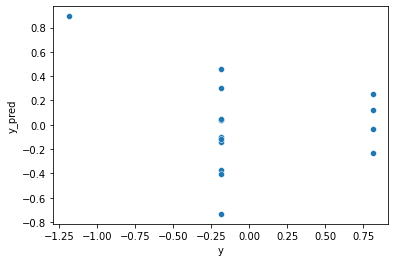

,y_pred
y,
-1.1875,0.893246
-0.1875,-0.090897
0.8125,0.026654



-0.6980498384701292
0.006424728453203566


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


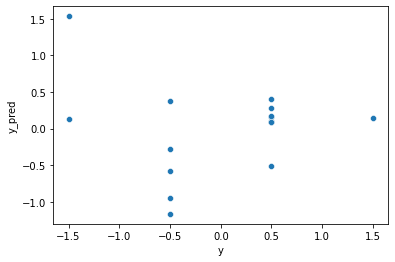

,y_pred
y,
-1.5,0.834699
-0.5,-0.518272
0.5,0.097880
1.5,0.138922



0.010491516954447944
0.12202811886583387

0.0844374050083605
0.1631709701488646

0.2600784555575354
0.2620191057619129

0.0533636296552068
0.10729304716228076

-0.1467582874632154
0.004703089997567484

0.1792010258115706
0.20078470144579388

0.4164755096371916
0.4669578456067222

0.37542237115969423
0.37707956588186314

0.33014958895990765
0.330160114165769

0.5900906808704061
0.6129815060425245

0.37170385046622023
0.38416798134225716

0.0802072705310578
0.09843571800016641

0.250880905809608
0.2605998375031534

-0.11671044505335537
0.09015540585043696

-0.015762941883230797
0.014330171743296457

-0.31235999227618216
0.023061337191002933

0.23598226532562283
0.2558628298361771

0.3306740472737616
0.34030233724732095

0.46725164609336156
0.4934023606130706

0.4882504422171091
0.536295510350368

-0.33896601262211146
0.0075551184877144205

0.17682921456353717
0.1812217703498723

0.34725047200174386
0.3493566890877516

0.06807828642946046
0.07443656617871695

0.152987904614724
0.26628402

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


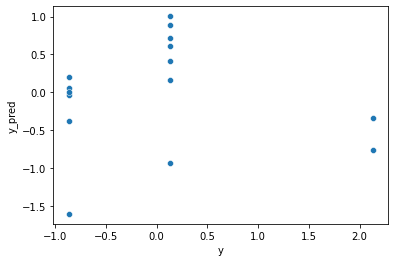

,y_pred
y,
-0.866667,-0.293924
0.133333,0.409360
2.133333,-0.550988



-0.21340534879463968
0.04276219899587336

0.650658541292797
0.6838160867221492

0.1684959441556687
0.17041265195176836

0.10371168936425768
0.11400892286253045

0.5257823423491246
0.6251300132093537

0.25112637693966555
0.2750821445399095

0.4877934912806242
0.507574937183257

0.0782261369707149
0.10638184532031379

0.02400918615127734
0.073351456992644

0.2028763464162926
0.20476531452249194

0.3823404434393729
0.3974464306522301

0.6512005851927234
0.7570647487453867

0.5667466103994994
0.5880741105620904

0.615074343214786
0.6162496284531994

0.5094733424670612
0.5098619310643442

0.6688408801367671
0.7445960310297964

0.2081151861691286
0.20931263392171714

0.452886913894031
0.5301671243831279

0.36539951780842594
0.447403359364267

0.18220155748903744
0.1825257489488327

0.3547134552342154
0.37461658805650866

-0.638449740346041
0.0008582334235844996


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


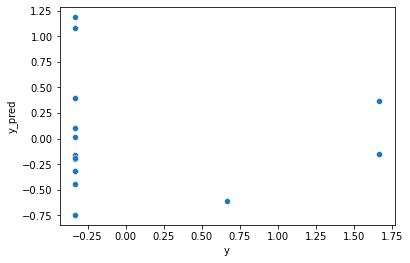

,y_pred
y,
-0.333333,0.032301
0.666667,-0.609751
1.666667,0.111067



-1.5656472593001856
0.013940156161229122


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


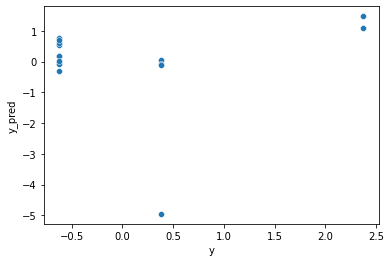

,y_pred
y,
-0.625,0.254167
0.375,-1.272716
2.375,1.274595



0.12543403165921196
0.15349829786314945

0.33627429814606047
0.3668784319148291

0.24324168168417704
0.2844461125734061

-0.24136973197168987
0.0131322795680643

0.23609823352619408
0.2492858888038382

0.22124690822617732
0.26284614713512483

0.5347041486229305
0.6048602226365314

0.1616016075968022
0.306556380149029

-0.24274681582202096
0.12877982390773232

-0.11349422766356954
0.1508114240213814



In [37]:
within_subj_predictions = []
for group in results['result_group'].unique():
    group_results = results.loc[results['result_group']==group,].copy()
    
    obs_mean = np.mean(group_results['y'])
    pred_mean = np.mean(group_results['y_pred'])
    obs_sd = np.std(group_results['y'])
    pred_sd = np.std(group_results['y_pred'])
    
    #let's standardize both.
    group_results['y'] = (group_results['y'] - obs_mean)
    group_results['y_pred'] = (group_results['y_pred'] - pred_mean)
    
    within_subj_prediction = r2_score(group_results['y'],group_results['y_pred'])
    print(within_subj_prediction)
    print(math.pow(pearsonr(group_results['y'],group_results['y_pred'])[0],2))

    
    #what if we we re-ranked the predicted values into groups along the 
    if (within_subj_prediction< (-0.5)):

        sp = sns.scatterplot(group_results['y'],group_results['y_pred'])
        plt.show()
        display(pd.DataFrame(group_results.groupby('y').y_pred.mean()))
        #display(group_results)
    within_subj_predictions = within_subj_predictions + [within_subj_prediction]
    print("")
    
r2_score_within_subj = np.mean(within_subj_predictions)

In [38]:
r2_score_within_subj

0.2506854934254319

In [39]:
r2_score(results['y'],results['y_pred'])

0.23184109193532398

## Rank based method

In [40]:
def rank_obs(group_results):
    #assign the predicted value ranks according to the observed data
    #i.e., we know how many of each class in our dataset; we just don't know which are which.
    obs_values_in_order = list(group_results['y'])
    obs_values_in_order.sort()

    group_results = group_results.sort_values('y_pred')
    group_results.reset_index(drop=True,inplace=True)

    for i in range(len(obs_values_in_order)):
        group_results.loc[i,'y_pred']  = obs_values_in_order[i]
        
    return(group_results)


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


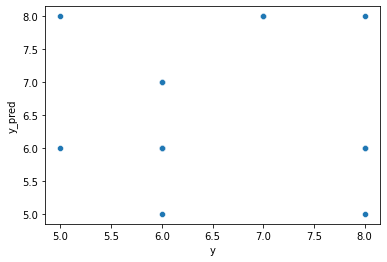

,y_pred
y,
5.0,7.000
6.0,6.125
7.0,8.000
8.0,6.250


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


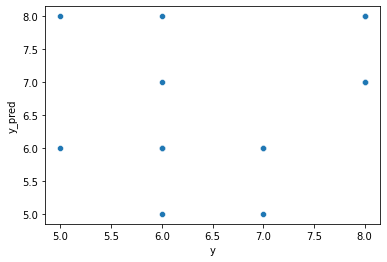

,y_pred
y,
5.0,7.000000
6.0,6.333333
7.0,5.666667
8.0,7.500000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


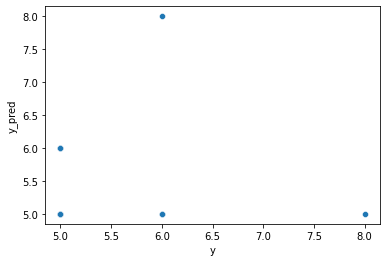

,y_pred
y,
5.0,5.375
6.0,6.000
8.0,5.000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


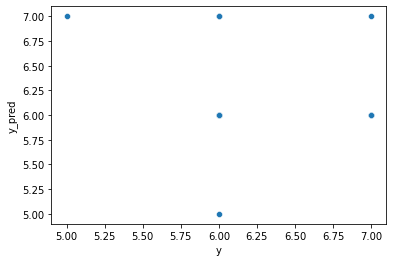

,y_pred
y,
5.0,7.000000
6.0,6.090909
7.0,6.250000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


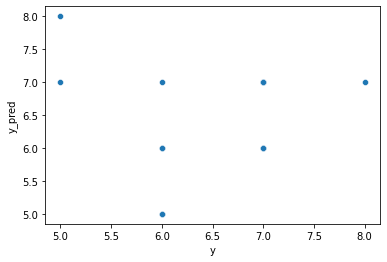

,y_pred
y,
5.0,7.500
6.0,5.800
7.0,6.625
8.0,7.000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


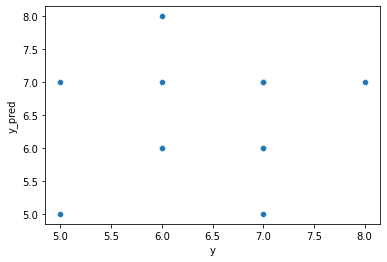

,y_pred
y,
5.0,6.00
6.0,6.75
7.0,6.50
8.0,7.00


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


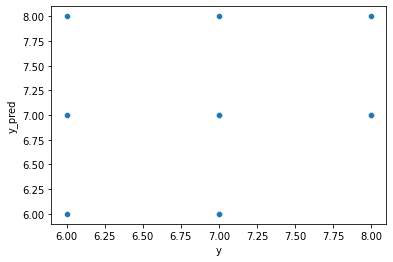

,y_pred
y,
6.0,7.000000
7.0,6.857143
8.0,7.333333


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


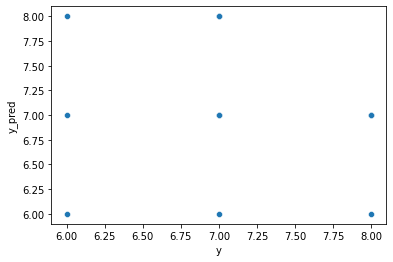

,y_pred
y,
6.0,7.000000
7.0,7.200000
8.0,6.666667


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


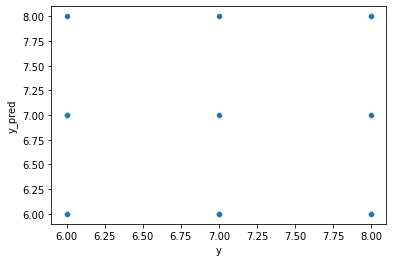

,y_pred
y,
6.0,7.00
7.0,6.60
8.0,7.25


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


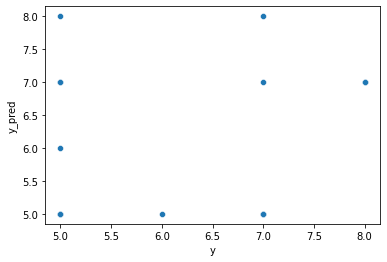

,y_pred
y,
5.0,6.142857
6.0,5.000000
7.0,6.000000
8.0,7.000000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


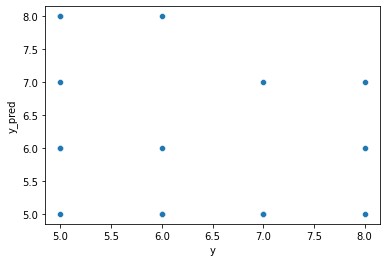

,y_pred
y,
5.0,6.666667
6.0,6.000000
7.0,5.666667
8.0,6.000000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


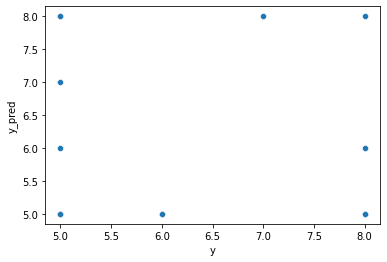

,y_pred
y,
5.0,6.125
6.0,5.000
7.0,8.000
8.0,6.000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


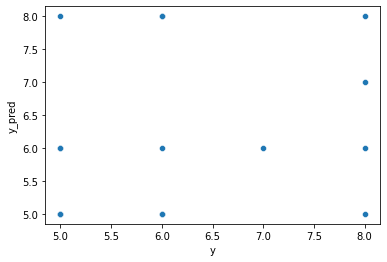

,y_pred
y,
5.0,5.833333
6.0,6.400000
7.0,6.000000
8.0,6.500000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


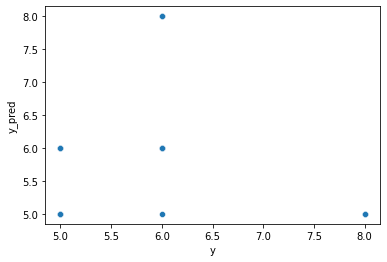

,y_pred
y,
5.0,5.500000
6.0,6.428571
8.0,5.000000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


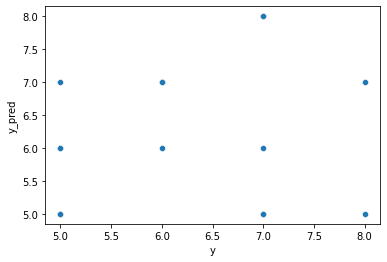

,y_pred
y,
5.0,5.80
6.0,6.75
7.0,6.40
8.0,6.00


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


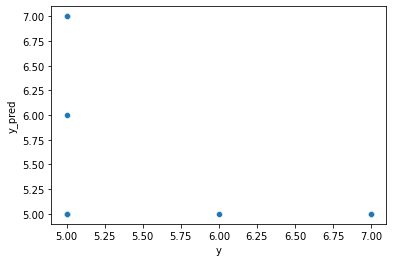

,y_pred
y,
5.0,5.416667
6.0,5.000000
7.0,5.000000


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


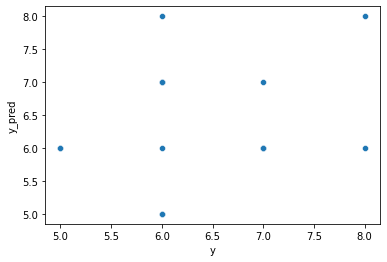

,y_pred
y,
5.0,6.000000
6.0,6.428571
7.0,6.250000
8.0,7.000000


In [41]:
within_subj_predictions = []
for group in results['result_group'].unique():
    group_results = rank_obs(results.loc[results['result_group']==group,].copy())
    
    #let's standardize both.
    #obs_mean = np.mean(group_results['y_obs'])
    #const_vals = np.repeat(obs_mean,len(group_results['y_pred']))
    within_subj_prediction = r2_score(group_results['y'],group_results['y_pred'])
    
    #what if we we re-ranked the predicted values into groups along the 
    if (within_subj_prediction< (-0.5)):

        sp = sns.scatterplot(group_results['y'],group_results['y_pred'])
        plt.show()
        display(pd.DataFrame(group_results.groupby('y').y_pred.mean()))
        print("")
        #display(group_results)
    within_subj_predictions = within_subj_predictions + [within_subj_prediction]

    
r2_score_within_subj = np.mean(within_subj_predictions)

In [42]:
r2_score_within_subj

0.022571679618909633

It's possible we need to do this but within-run instead of within-subject...

In [43]:
within_subj_predictions

[0.4181818181818182,
 0.8333333333333334,
 0.9,
 0.33333333333333337,
 -0.4788732394366195,
 0.39811912225705326,
 0.1428571428571429,
 0.323943661971831,
 0.5222929936305734,
 0.19642857142857162,
 0.4385964912280702,
 0.533678756476684,
 -0.15315315315315314,
 0.27586206896551735,
 -1.0,
 -0.5384615384615385,
 0.01754385964912264,
 0.17177914110429449,
 0.48275862068965525,
 -0.1470588235294117,
 -0.3953488372093019,
 0.7,
 0.2440944881889764,
 -0.25984251968503935,
 -0.14406779661016933,
 0.1215686274509804,
 0.4651810584958217,
 0.2195121951219512,
 0.2638036809815951,
 0.1724137931034483,
 0.6353276353276354,
 0.5884244372990354,
 -1.0,
 0.5522388059701492,
 0.9178885630498533,
 0.6319018404907976,
 -1.2535211267605635,
 -1.0,
 -0.6438356164383556,
 -0.3999999999999999,
 0.10344827586206917,
 -0.6666666666666667,
 -1.3333333333333335,
 -0.5,
 0.2647058823529411,
 0.19999999999999996,
 0.16883116883116878,
 0.471947194719472,
 0.2727272727272727,
 -0.7920000000000003,
 0.4615384615

In [44]:
r2_score_within_subj

0.022571679618909633

Have to understand how pearson's r and this R2 measure vary...

### What if we use Pearson's R?

In [48]:
within_subj_predictions = []
for group in results['result_group'].unique():
    group_results = results.loc[results['result_group']==group,].copy()
    
    #get means and SDs
    obs_mean = np.mean(group_results['y'])
    pred_mean = np.mean(group_results['y_pred'])
    obs_sd = np.std(group_results['y'])
    pred_sd = np.std(group_results['y_pred'])
    
    #mean center
    group_results['y'] = (group_results['y'] - obs_mean)
    group_results['y_pred'] = (group_results['y_pred'] - pred_mean)
    
    within_subj_prediction = pearsonr(group_results['y'],group_results['y_pred'])[0]
    print(within_subj_prediction)
    print(math.pow(pearsonr(group_results['y'],group_results['y_pred'])[0],2))

    
    #what if we we re-ranked the predicted values into groups along the 
    if (within_subj_prediction< (-0.5)):

        sp = sns.scatterplot(group_results['y'],group_results['y_pred'])
        plt.show()
        display(pd.DataFrame(group_results.groupby('y').y_pred.mean()))
        #display(group_results)
    within_subj_predictions = within_subj_predictions + [within_subj_prediction]
    print("")
    
r2_score_within_subj = np.mean(within_subj_predictions)

0.6355191115883931
0.4038845411941005

0.8765515040367327
0.7683425392290582

0.9175281304740015
0.8418578702111164

0.7306319960712073
0.5338231136829967

0.33065661947544445
0.10933380000292887

0.6799549581614326
0.4623387451283155

0.6688281036372383
0.44733103221498444

0.6886246755887041
0.474203943829648

0.7348734182234362
0.5400389408113974

0.5544998166007582
0.3074700466102745

0.8222859889302135
0.6761542475909392

0.6987988479786686
0.48831982993631445

0.48921792581916823
0.2393341789428092

0.6711310092654328
0.45041683159763846

0.11150170045131505
0.01243262920353479

0.21910831009156212
0.048008451551180144

0.6009749396035073
0.36117087803143927

0.6822397360408587
0.4654510574331006

0.5852749078690458
0.34254671778112006

0.5370237586280866
0.28839451733103744

0.34986629412478143
0.12240642376460807

0.7806399003479192
0.6093986540152092

0.676552940232496
0.4577238809372353

0.6035817095664091
0.364310880123109

0.4750350885206337
0.2256583353258063

0.5463028464

In [53]:
math.pow(r2_score_within_subj,2)

0.2874040115034314

In [54]:
math.pow(pearsonr(results['y'],results['y_pred'])[0],2)

0.24511572191909237

Using Pearsons' r does not really improve things. The by-subject-run $r$ is around the same as the individual r. Although 0.04 higher is not nothing.

So can we do _calibration_ or _learning_ within-subject somehow?